In [1]:
#%load_ext pyinstrument

# Generating Synthetic Power Grids topologies using ERG 

In [2]:
#importing libraries

import warnings
warnings.filterwarnings("ignore")

import load_pglib_opf as lp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pg_utils as sc
from tqdm import tqdm
import new_code.pg_ergm_numba as est
import new_code.pg_obs_numba as hc
import matplotlib.pylab as pylab
import os
import pickle

### Reference Grid selection

In the next cell we select the model type as well as the reference grid

In [3]:
mod_type = '_edg_tri_2tri'
obs_comp = getattr(hc,'obs'+mod_type)
fast_obs_comp = getattr(hc,'fast_obs'+mod_type)
name='1354_pegase'
rmean_list=[]

In [4]:
#create file used to store the estimation results
results_path = os.path.join("results", name, mod_type)
os.makedirs(results_path, exist_ok=True)
filepath = os.path.join(results_path, "estimation_results_"+name+mod_type+".txt")


#parsing the .m file into a suitable format, and perform some sanity checks
ordmat,ordlist,buslist,countlist = lp.pow_parser(name)
print("Number of connecetd components in the graph:" ,nx.number_connected_components(nx.from_numpy_array(ordmat)))
k1,k2,k3,q1,q2,q3 = hc.avg_degreetype(ordmat,ordlist)
genobs = hc.obs_edg_tri_2tri(ordmat,q1,q2,q3)
countlist = [q1,q2,q3]
print(countlist)

Number of connecetd components in the graph: 1
[260, 12, 1082]


### Parameter Estimation

In the following we generate a starting point for the betas estimation. The EE method works in principle with any starting point, provided that is 'close enough' to the target point. Our experiments showed that the algorithm converges if the parameters in the starting point have the same sign and are of the same order of magnitude as the real ones. Thus, in the following cell we compute, among other quantities, the analytical value of the (edge-)parameters according to the free-energy partial derivatives (see https://doi.org/10.48550/arXiv.1210.7828). For the k-triangle count parameters we use an educated guess.

In [5]:
obs,betas = hc.comp_obs_and_betas(mod_type,ordmat,ordlist,countlist,startguess=np.array([1, -1]))
n = len(ordmat)
startconn1 = est.generate_connected_adj(n)
randper = np.random.permutation(n)
startconn = est.reorder_rows(startconn1,randper)
mix = n*n*np.log(n)
print(betas)
step = int(n/3)

greedsearch_param2: 100%|██████████| 7000/7000 [00:01<00:00, 4690.29it/s]


[  -6.435   -7.645   -7.04  -192.5     -7.865   -6.875    1.      -1.   ]


To better visualize how the algorithm work we choose as a starting point an educated guess of sign and magnitude of each parameter based on the previous estimation.

In [ ]:
betas = np.array([-5.5,-5.5,-5.5,-20,-5.5,-5.5,1.5,-0.5], dtype=float)
EEparams,obslist,parlist = est.EEsparse_with_timer(ordmat,obs,betas,countlist,obs_comp,fast_obs_comp,80000000,0.001,0.001,step)

[#############################-] 100.0% | Elapsed: 4100.6s | ETA: 0.1sss
Completed 60000000 iterations in 4100.64s


In [7]:
print("Estimated parameters:", EEparams)

Estimated parameters: [ -6.24346074  -7.68720074  -6.66940504 -20.          -8.28571733
  -6.60965298   1.85911897  -0.5161475 ]


We now show the stochastic trajectory of each parameter's updates. Notice how upon reaching convergence the parameters start to oscillate.

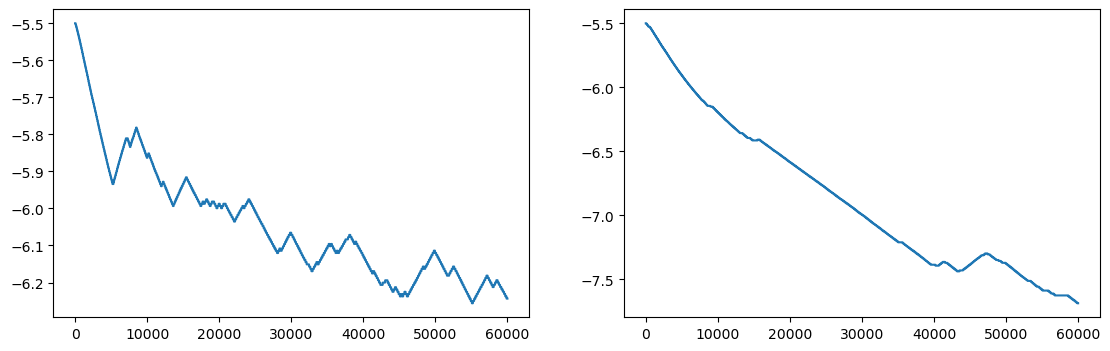

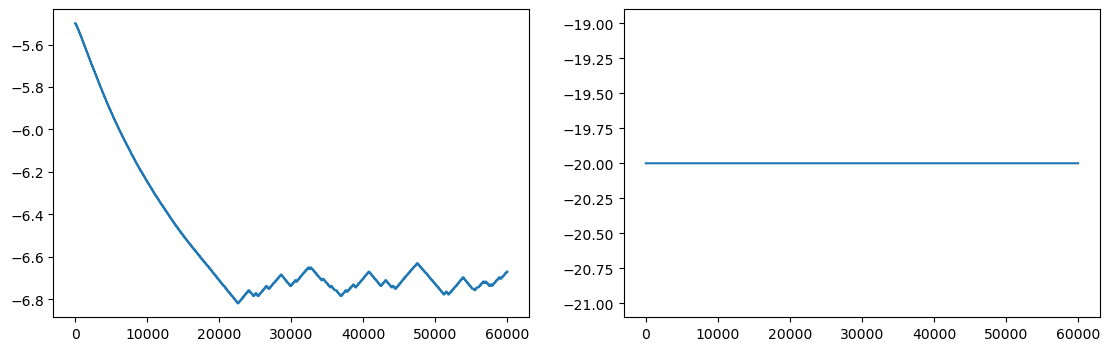

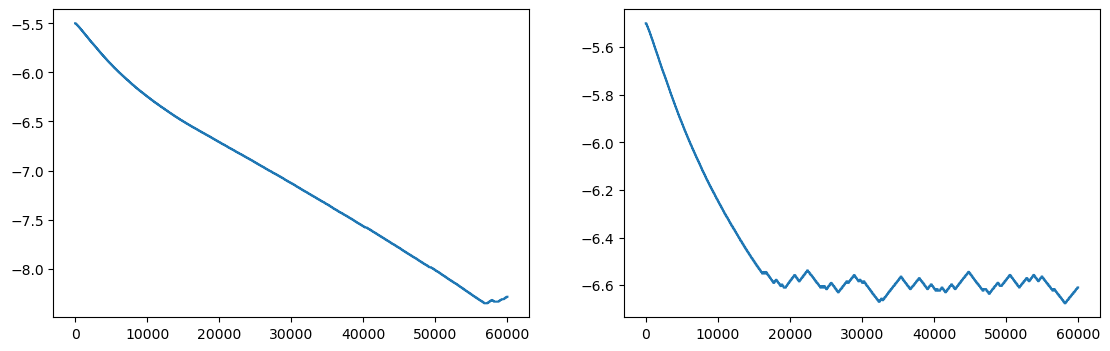

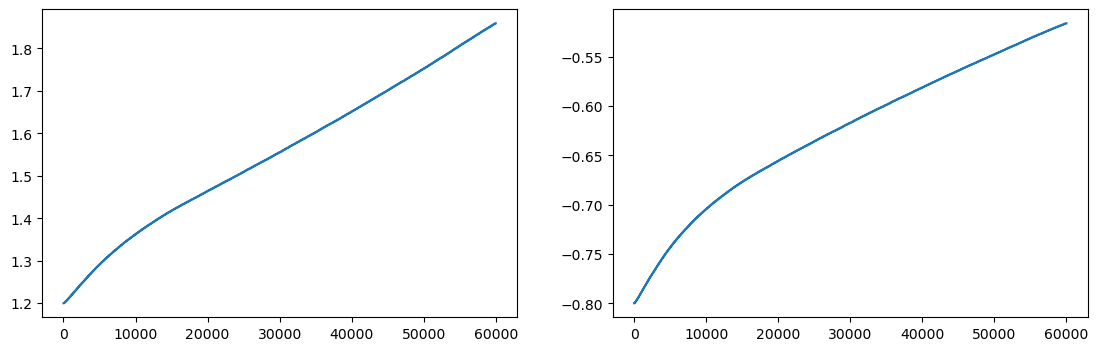

In [8]:
#plotting the parameters' trajectories during the EE algorithm

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols= 2, figsize=(13.5,4))
#ax0.set_title("Generator-Generator Edge parameter", fontsize = 20)
ax0.plot(parlist[0])
#ax1.set_title("Generator-Load Edge parameter", fontsize = 20)
ax1.plot(parlist[1])
plt.savefig(os.path.join(results_path, "nt"+mod_type+name+'parmater diagnostics0.svg'),dpi=300, format="svg")
plt.show()
fig, (ax2,ax3) = plt.subplots(nrows=1,ncols= 2, figsize=(13.5,4))
#ax2.set_title("Generator-Interconnection Edge parameter", fontsize = 20)
ax2.plot(parlist[2])
#ax3.set_title("Load-Load Edge parameter", fontsize = 20)
ax3.plot(parlist[3])
plt.savefig(os.path.join(results_path, "nt"+mod_type+name+'parmater diagnostics1.svg'),dpi=300, format="svg")
plt.show()
fig,(ax4,ax5) = plt.subplots(nrows=1,ncols= 2, figsize=(13.5,4))
#ax4.set_title("Load-Interconnection Edge parameter", fontsize = 20)
ax4.plot(parlist[4])
#ax5.set_title("Interconnection-Interconnection Edge parameter", fontsize = 20)
ax5.plot(parlist[5])
plt.savefig(os.path.join(results_path, "nt"+mod_type+name+'parmater diagnostics2.svg'),dpi=300, format="svg")
plt.show()
fig2,(ax20,ax21) = plt.subplots(nrows=1,ncols=2,figsize=(13.5,4))
#ax20.set_title("triangles parameter", fontsize = 20)
ax20.plot(parlist[6])
#ax21.set_title("2-triangles parameter", fontsize = 20)
ax21.plot(parlist[7])
plt.savefig(os.path.join(results_path, "nt"+mod_type+name+'parmater diagnostics3.svg'),dpi=300, format="svg")
plt.show()

In [9]:
print("Estimated parameters:", EEparams)

Estimated parameters: [ -6.24346074  -7.68720074  -6.66940504 -20.          -8.28571733
  -6.60965298   1.85911897  -0.5161475 ]


### Constrained Monte-Carlo sampling

We proceed to the actual generative part of our methodology by using the parameters estimated previously and the algorithm for constrained Monte-Carlo sampling introduced in https://doi.org/10.48550/arXiv.1806.11276

In [10]:
#monte-carlo sampling with the constrained algorithm
#mean_list,synth,obslist = est.pg_MHergm_conn(startconn,obs,EEparams,countlist, obs_comp,fast_obs_comp,7000000)
mean_list,synth,obslist = est.pg_MHergm_conn_timer(startconn,obs,EEparams,countlist, obs_comp,fast_obs_comp,5000000)

print("The procedure has generated "+str(len(synth))+" synthetic samples")
sellist = [mat.toarray() for mat in synth]
Glist2,clustlist,avg_typedeg,ac_list = sc.synth_selection2(sellist,ordlist)

[#############################-] 100.0% | Accepted: 13232 | Elapsed: 43.2s | ETA: 0.0s
Completed 5000000 MH iterations in 43.22s
Total accepted moves: 13233
The procedure has generated 1153 synthetic samples


100%|██████████| 1153/1153 [00:01<00:00, 1102.39it/s]


In [11]:
def feature_translator(el):
    if el==1:
        name='generator'
    elif el==2:
        name='load'
    elif el==3:
        name='interconnection'
    else:
        name='unknown_bus'
    return(name)


In [12]:
feat_mtx = [feature_translator(el) for el in list(ordlist)]


In [13]:
dataset = [sellist, feat_mtx]

Next, we plot some of the statiscs of interest for each generated network. In red it is reported the value of the statistic for the reference grid whereas in green it is reported the average value of the statistic across the generated ensemble.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


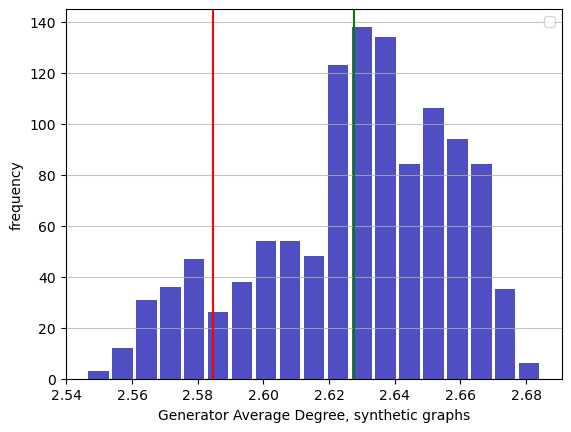

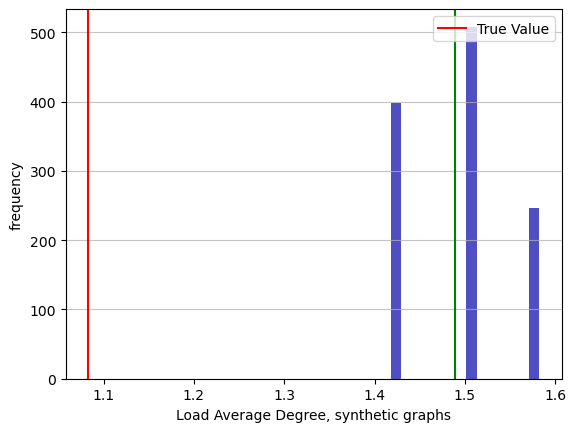

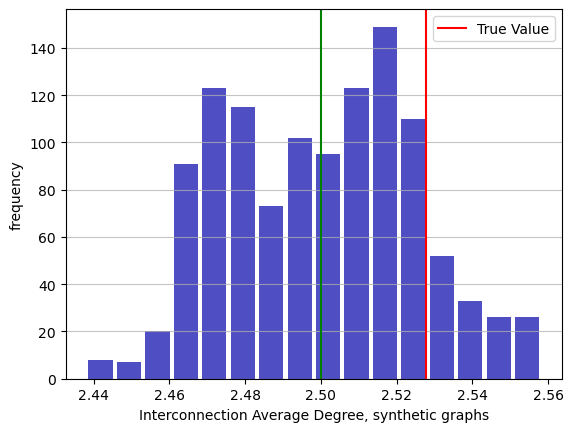

100%|██████████| 1153/1153 [00:07<00:00, 161.40it/s]


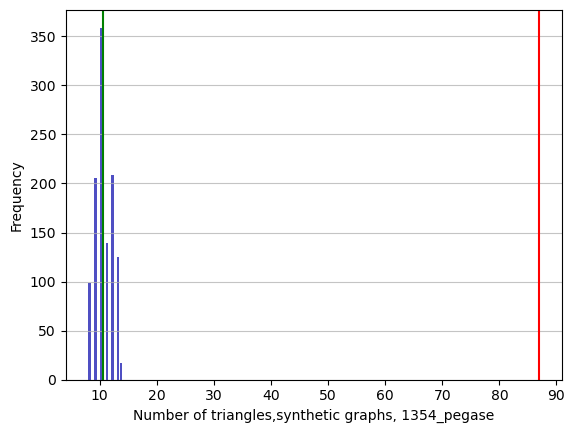

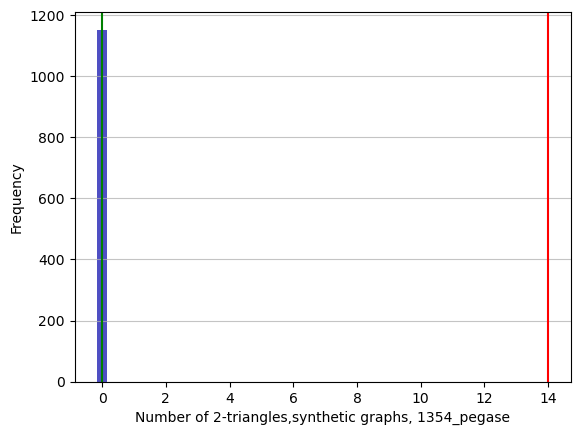

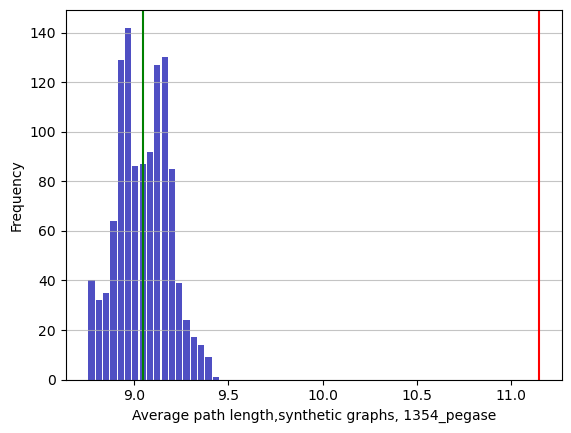

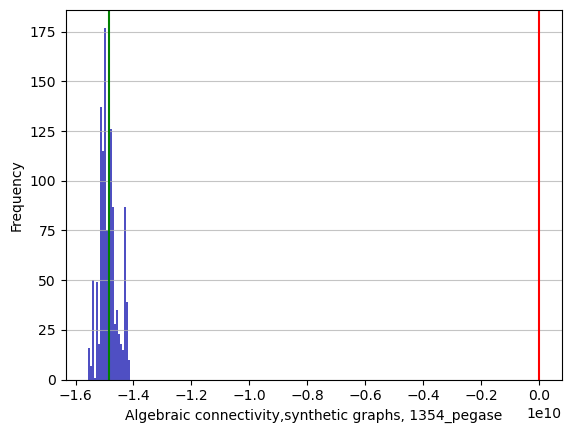

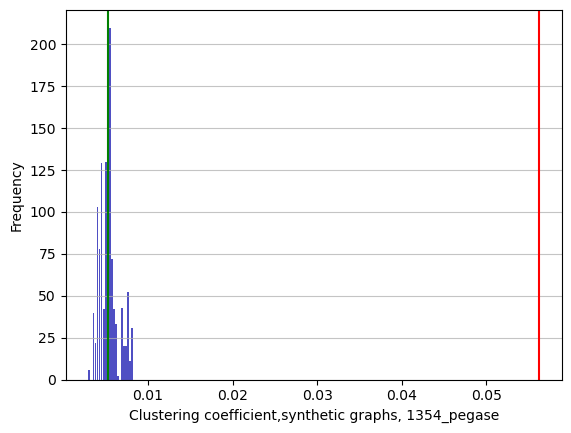

In [14]:
#plotting the results

degarray = np.array(avg_typedeg).T

n, bins, patches = plt.hist(x=degarray[0], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Generator Average Degree, synthetic graphs')
plt.ylabel('frequency')
#plt.title('Generators,'+name)
plt.axvline(x=k1,color='red')
plt.axvline(x=np.mean(degarray[0]),color='green')
maxfreq = n.max()
plt.legend(loc='upper right')
plt.savefig(os.path.join(results_path, 'sdeggens'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()

rmean_list.append(k1)





n, bins, patches = plt.hist(x=degarray[1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Load Average Degree, synthetic graphs')
plt.ylabel('frequency')
#plt.title('Loads, '+name)
plt.axvline(x=k2,color='red',label='True Value')
plt.axvline(x=np.mean(degarray[1]),color='green')
maxfreq = n.max()
plt.legend(loc='upper right')
plt.savefig(os.path.join(results_path, 'sdeglods'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()

rmean_list.append(k2)




n, bins, patches = plt.hist(x=degarray[2], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Interconnection Average Degree, synthetic graphs')
plt.ylabel('frequency')
#plt.title('Interconnections, '+name)
plt.axvline(x=k3,color='red',label='True Value')
plt.axvline(x=np.mean(degarray[2]),color='green')
maxfreq = n.max()
plt.legend(loc='upper right')
plt.savefig(os.path.join(results_path, 'sdegints'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()

rmean_list.append(k3)



trilist = []
for i in tqdm(range(len(Glist2))):
    trilist.append(sum(nx.triangles(Glist2[i].to_undirected()).values())/3)
trilist2 = [hc.compute_2_triangle(mat) for mat in tqdm(sellist)]


n, bins, patches = plt.hist(x=trilist, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of triangles,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Triangles, '+name)
plt.axvline(x=genobs[6],color='red')
plt.axvline(x=np.mean(trilist),color='green')
plt.savefig(os.path.join(results_path, 'stris'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()

rmean_list.append(genobs[6])



n, bins, patches = plt.hist(x=trilist2, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.3)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of 2-triangles,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('2-Triangles, '+name)
plt.axvline(x=genobs[7],color='red')
plt.axvline(x=np.mean(trilist2),color='green')
plt.savefig(os.path.join(results_path, 's2tris'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()

rmean_list.append(genobs[7])

paths = [nx.average_shortest_path_length(G.to_undirected()) for G in Glist2]
n, bins, patches = plt.hist(x=paths, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Average path length,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Avgerage path, '+name)
plt.axvline(x=nx.average_shortest_path_length(nx.from_numpy_array(ordmat).to_undirected()),color='red')
plt.axvline(x=np.mean(paths),color='green')
plt.savefig(os.path.join(results_path, 'apl'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()
rmean_list.append(nx.average_shortest_path_length(nx.from_numpy_array(ordmat).to_undirected()))




n, bins, patches = plt.hist(x=ac_list, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Algebraic connectivity,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Algebraic connectivity, '+name)
plt.axvline(x=sc.alg_conn(ordmat),color='red')
plt.axvline(x=np.mean(ac_list),color='green')
plt.savefig(os.path.join(results_path, 'algconn'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()
rmean_list.append(sc.alg_conn(ordmat))


clusts = [sc.clustering_coeff(G.to_undirected()) for G in Glist2]
n, bins, patches = plt.hist(x=clusts, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Clustering coefficient,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Avgerage path, '+name)
plt.axvline(x=sc.clustering_coeff(nx.from_numpy_array(ordmat).to_undirected()),color='red')
plt.axvline(x=np.mean(clusts),color='green')
plt.savefig(os.path.join(results_path, 'clustcoeff'+mod_type+name+'.svg'),dpi=300, format="svg")
plt.show()
rmean_list.append(sc.clustering_coeff(nx.from_numpy_array(ordmat).to_undirected()))


In [15]:
PIK1 = f"graph_list_{name}_pickle.dat"
pik_path1 = os.path.join(results_path, PIK1)
data = Glist2
with open(pik_path1, "wb") as f:
    pickle.dump(data, f)

In [16]:
PIK2 = f"graph_data_{name}_pickle.dat"
pik_path2 = os.path.join(results_path, PIK2)    
data = dataset
with open(pik_path2, "wb") as f:
    pickle.dump(data, f)